### 1. import library

In [1]:
# 라이브러리 호출

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../file/train_add_category.csv')
df = df.drop(['Unnamed: 0','predicted'], axis=1)
df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,category
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,dog
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,cat
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,cat
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,dog
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,cat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15,dog
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70,cat
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20,cat
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20,dog


### 2. split data

In [3]:
data = df.drop('Pawpularity', axis=1)
target = df['Pawpularity']

data['category'].replace('dog',0, inplace=True)
data['category'].replace('cat',1, inplace=True)
data.drop('Id', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.25, random_state=0)

### 3. SVR

In [4]:
from sklearn.svm import SVR

model = SVR()
model.fit(X_train, y_train)

relation_square = model.score(X_train, y_train)
print('결정계수 R :', relation_square)

결정계수 R : -0.04378579199378141


In [5]:
# plt.scatter(X_train, y_train, marker = '+')
# plt.scatter(X_test, y_p, marker = 'o')
# plt.show()

from sklearn.metrics import mean_squared_error

y_p = model.predict(X_test)
RMSE = mean_squared_error(y_test, y_p)**0.5
print(f"predict accuracy : {RMSE}")

predict accuracy : 21.153902807750118


In [6]:
for i in ('linear', 'rbf', 'poly'):
    model = SVR(kernel = i)
    model.fit(X_train, y_train)
    relation_square = model.score(X_train, y_train)
    print('kernel: ',i)
    print('결정계수 R :', relation_square)
    RMSE = mean_squared_error(y_test, y_p)**0.5
    print(f"predict accuracy : {RMSE}")
    print('################################################')

kernel:  linear
결정계수 R : -0.05940636202532534
predict accuracy : 21.153902807750118
################################################
kernel:  rbf
결정계수 R : -0.04378579199378141
predict accuracy : 21.153902807750118
################################################
kernel:  poly
결정계수 R : -0.04291598401688801
predict accuracy : 21.153902807750118
################################################


### 4. XGboost 

In [38]:
import xgboost as xgb
from xgboost import plot_importance

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# XGBoost를 사용하기 위해 DMatrix 형태로 변환
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

# 모델 생성
# num_boost_round 만큼 반복하는데 early_atopping_rounds 만큼 성능 향상이 없으면 중단
# early_stopping_rounds를 사용하려면 eval 데이터 셋을 명기해야 함
params = {'max_depth':5, # 트리 최대 깊이
        'eta':0.1, # 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값
        'objective':'multi:softmax', # 다중분류일 때 적용
        'num_class':101 , # 데이터 집합에 있는 클래스 수
        'eval_metric':'merror', # Multiclass classification error rate
        'early_stoppings':100}
num_rounds = 400

# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round=num_rounds,
                     early_stopping_rounds=100, evals=wlist)

[17:45:16] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.95574	eval-merror:0.97377
[1]	train-merror:0.95440	eval-merror:0.97256
[2]	train-merror:0.95238	eval-merror:0.97256
[3]	train-merror:0.95252	eval-merror:0.97337
[4]	train-merror:0.94969	eval-merror:0.97337
[5]	train-merror:0.94821	eval-merror:0.97458
[6]	train-merror:0.94834	eval-merror:0.97296
[7]	train-merror:0.94673	eval-merror:0.97215
[8]	train-merror:0.94552	eval-merror:0.97337
[9]	train-merror:0.94539	eval-merror:0.97337
[10]	train-merror:0.94391	eval-merror:0.97256
[11]	train-merror:0.94431	eval-merror:0.97337
[12]	train-merror:0.94350	eval-merror:0.97417
[13]	train-merror:0.94283	eval-merror:0.97175
[14]	train-merror:0.94243	eval-

[170]	train-merror:0.91714	eval-merror:0.96852
[171]	train-merror:0.91700	eval-merror:0.96852
[172]	train-merror:0.91700	eval-merror:0.96852
[173]	train-merror:0.91700	eval-merror:0.96852
[174]	train-merror:0.91700	eval-merror:0.96852
[175]	train-merror:0.91673	eval-merror:0.96852
[176]	train-merror:0.91687	eval-merror:0.96852
[177]	train-merror:0.91687	eval-merror:0.96852
[178]	train-merror:0.91687	eval-merror:0.96852
[179]	train-merror:0.91687	eval-merror:0.96852
[180]	train-merror:0.91673	eval-merror:0.96852
[181]	train-merror:0.91673	eval-merror:0.96852
[182]	train-merror:0.91687	eval-merror:0.96852
[183]	train-merror:0.91673	eval-merror:0.96852
[184]	train-merror:0.91673	eval-merror:0.96852
[185]	train-merror:0.91660	eval-merror:0.96852
[186]	train-merror:0.91660	eval-merror:0.96852
[187]	train-merror:0.91660	eval-merror:0.96852
[188]	train-merror:0.91660	eval-merror:0.96852
[189]	train-merror:0.91646	eval-merror:0.96852
[190]	train-merror:0.91646	eval-merror:0.96852
[191]	train-m

[345]	train-merror:0.91001	eval-merror:0.96893
[346]	train-merror:0.91001	eval-merror:0.96893
[347]	train-merror:0.90974	eval-merror:0.96893
[348]	train-merror:0.91001	eval-merror:0.96852
[349]	train-merror:0.91001	eval-merror:0.96852
[350]	train-merror:0.90974	eval-merror:0.96893
[351]	train-merror:0.90960	eval-merror:0.96893
[352]	train-merror:0.90960	eval-merror:0.96893
[353]	train-merror:0.90960	eval-merror:0.96893
[354]	train-merror:0.90960	eval-merror:0.96893
[355]	train-merror:0.90974	eval-merror:0.97014
[356]	train-merror:0.90974	eval-merror:0.97014
[357]	train-merror:0.90974	eval-merror:0.97014
[358]	train-merror:0.90974	eval-merror:0.97014
[359]	train-merror:0.90960	eval-merror:0.97014
[360]	train-merror:0.90960	eval-merror:0.97014
[361]	train-merror:0.90960	eval-merror:0.97014
[362]	train-merror:0.90960	eval-merror:0.97014
[363]	train-merror:0.90960	eval-merror:0.97014
[364]	train-merror:0.90960	eval-merror:0.96973
[365]	train-merror:0.90960	eval-merror:0.97014
[366]	train-m

In [39]:
pred_probs = xgb_model.predict(dtest)
print('수행 결과 값')
print(pred_probs)

xgb_RMSE = mean_squared_error(y_test, pred_probs)**0.5
print(f"predict accuracy : {xgb_RMSE}")

수행 결과 값
[29. 84. 35. ... 31. 31. 45.]
predict accuracy : 25.38881662632644


### 6. scikit-learn wrapper XGboost

In [41]:
# 사이킷런 래퍼 XGboost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, eval_metric='merror')
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [42]:
print('수행 결과 값')
print(w_preds)

w_xgb_RMSE = mean_squared_error(y_test, w_preds)**0.5
print(f"predict accuracy : {w_xgb_RMSE}")

수행 결과 값
[29 84 29 ... 28 31 24]
predict accuracy : 26.50948175810179


### 7. XGB Regression

In [43]:
R_xgb_model = xgb.XGBRegressor(n_estimators=400, learning_rate=0.1, #gamma=0, subsample=0.75,colsample_bytree=1,
                               max_depth=3, eval_metric='merror')
R_xgb_model.fit(X_train, y_train)
R_preds = R_xgb_model.predict(X_test)

In [44]:
print('수행 결과 값')
print(R_preds)

R_xgb_RMSE = mean_squared_error(y_test, R_preds)**0.5
print(f"predict accuracy : {R_xgb_RMSE}")

수행 결과 값
[37.42125  45.408638 35.658863 ... 37.541405 38.602695 33.98282 ]
predict accuracy : 20.74411938113497


### 8. visualization

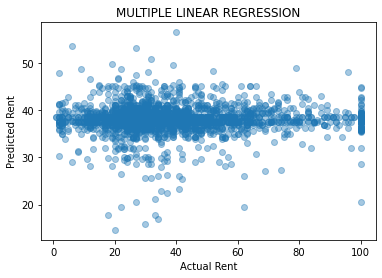

In [48]:
import matplotlib.pyplot as plt

plt.scatter(y_test, R_preds, alpha=0.4)
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()